In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split 
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import mean_squared_error as mse
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error as mse
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline


pd.options.display.max_columns = 500 # ограничение на кол-во отображаемых столбцов

In [3]:
data = pd.read_csv('autos.csv')
data.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner
0,Maruti 800 AC,2007,60000,70000,Petrol,Individual,Manual,First Owner
1,Maruti Wagon R LXI Minor,2007,135000,50000,Petrol,Individual,Manual,First Owner
2,Hyundai Verna 1.6 SX,2012,600000,100000,Diesel,Individual,Manual,First Owner
3,Datsun RediGO T Option,2017,250000,46000,Petrol,Individual,Manual,First Owner
4,Honda Amaze VX i-DTEC,2014,450000,141000,Diesel,Individual,Manual,Second Owner


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4340 entries, 0 to 4339
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   name           4340 non-null   object
 1   year           4340 non-null   int64 
 2   selling_price  4340 non-null   int64 
 3   km_driven      4340 non-null   int64 
 4   fuel           4340 non-null   object
 5   seller_type    4340 non-null   object
 6   transmission   4340 non-null   object
 7   owner          4340 non-null   object
dtypes: int64(3), object(5)
memory usage: 271.4+ KB


In [5]:
#прологарифмируем таргет

X = data.drop("selling_price", axis=1)
y = data["selling_price"]
y = y.apply(np.log1p)

In [6]:
#проверем размерность таргета
y

0       11.002117
1       11.813037
2       13.304687
3       12.429220
4       13.017005
          ...    
4335    12.923912
4336    12.923912
4337    11.608245
4338    13.670486
4339    12.323860
Name: selling_price, Length: 4340, dtype: float64

In [9]:
#разделение на трейн и тест
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [12]:
#Реализуем  MeanTargetEncoder
#Разделение колонок на категориальные и числовые.
object_cols = ['name', 'year', 'fuel', 'seller_type', 'transmission', 'owner']
num_cols = ['km_driven']

In [14]:
class MeanTargetEncoderNoise(BaseEstimator, TransformerMixin):
    
    def __init__(self, categorical, numeric):
        self.categorical = categorical
        self.numeric = numeric
    
    def fit(self, X, y):
        
        c = 0.006

        X_fit = X.copy()
        y_fit = y.copy()
        
        X_fit[self.categorical] = X_fit[self.categorical].astype(object)
        
        X_with_target = pd.concat((X_fit, y_fit), axis=1)
        
        self.dict_of_means = {col : X_with_target.groupby(col)['selling_price'].mean() + c*np.random.normal(0, 1, 1)[0]
                              for col in self.categorical}        

        return self
        
    def transform(self, df):
        
        cols = [
            "km_driven",
            "name",
            "year",
            "fuel",
            "seller_type",
            "transmission",
            "owner"
        ]        
        
        df_ = df.copy()
        
        for col in self.categorical:
                df_[col] = df_[col].map(self.dict_of_means[col])    
                
                mean_value = self.dict_of_means[col].values.mean()
                
                df_[col] = df_[col].fillna(mean_value) 
        
        return  df_.reindex(cols, axis=1)

In [15]:
transformer = MeanTargetEncoderNoise(categorical=object_cols, numeric=num_cols)
transformer.fit(X_train, y_train)

MeanTargetEncoderNoise(categorical=['name', 'year', 'fuel', 'seller_type',
                                    'transmission', 'owner'],
                       numeric=['km_driven'])

In [16]:
#Проверка работы трансформера.
np.random.seed(1)

transformer = MeanTargetEncoderNoise(categorical=object_cols, numeric=num_cols)

transformer.fit(X_train, y_train)

train = transformer.transform(X_train)
test = transformer.transform(X_test)

train.head(10)

,km_driven,name,year,fuel,seller_type,transmission,owner
3294,50000,13.478865,13.435892,13.085954,12.611658,13.776443,12.959126
2290,70000,12.125200,11.906484,12.450179,12.611658,13.776443,12.959126
874,50000,12.311508,13.333058,12.450179,12.611658,12.643381,12.959126
1907,92198,12.493842,13.053677,12.450179,13.140882,12.643381,12.446379
3244,3240,12.401697,12.857085,12.450179,12.611658,12.643381,12.446379
1089,10000,12.700306,13.435892,12.450179,13.140882,12.643381,12.959126
3902,90000,11.706636,11.499783,12.450179,12.611658,12.643381,11.856591
2215,79000,11.131568,11.499783,12.450179,12.611658,12.643381,12.446379
3862,99700,13.181725,13.333058,13.085954,12.611658,12.643381,12.959126
705,124000,13.008906,12.241803,13.085954,12.611658,12.643381,12.446379


In [17]:
#Обучим несколько деревьев
#Списки гиперпараметров 
max_depth_list = [3, 5, 8, 12]
min_samples_split_list = [10, 50, 100, 500]
min_impurity_decrease_list = [0, 0.1, 0.15, 0.2]
max_leaf_nodes_list = [100, 200, 500]

In [21]:


np.random.seed(1)

mse_list=[]

for d in max_depth_list:
    pipe = Pipeline([("custom_transformer",
                  MeanTargetEncoderNoise(categorical=object_cols, numeric=num_cols)),
                  
                  
                 ("decision_tree", 
                  DecisionTreeRegressor(max_depth=d))])   

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    mse_list.append(mse(y_test, y_pred))  
    
print(mse_list)

[0.2386353595066422, 0.2238952029837222, 0.2115238838043318, 0.17867253044505008]


Text(0.5, 1.0, 'MSE vs Max Depth')

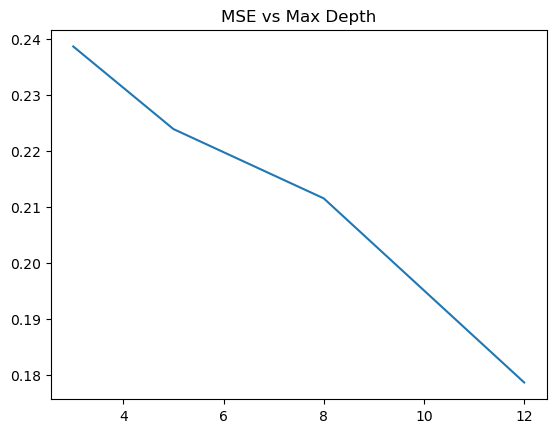

In [22]:
#построим график зависимости MSLE на тестовой выборке от значения гиперпараметра.
sns.lineplot(y = mse_list, x = max_depth_list)
plt.title("MSE vs Max Depth")

In [26]:
#строим конвейер Pipeline

pipe = Pipeline([("custom_transformer",
                  MeanTargetEncoderNoise(categorical=object_cols, numeric=num_cols)),
                  
                  
                 ("decision_tree", 
                  DecisionTreeRegressor())])
#Создадим сетку пораметров 
param_grid = {
    "decision_tree__max_depth": [3, 5, 8, 12],
    "decision_tree__min_samples_split": [10, 50, 100, 500],
    "decision_tree__min_impurity_decrease": [0, 0.1, 0.15, 0.2],
    "decision_tree__max_leaf_nodes": [100, 200, 500]
}
#начальное значение генератора
np.random.seed(1)


# оцним качество модели на основе среднеквадратичной ошибки (MSE) и выбирать лучшие гиперпараметры
search = GridSearchCV(pipe, param_grid, scoring='neg_mean_squared_error')
search.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('custom_transformer',
                                        MeanTargetEncoderNoise(categorical=['name',
                                                                            'year',
                                                                            'fuel',
                                                                            'seller_type',
                                                                            'transmission',
                                                                            'owner'],
                                                               numeric=['km_driven'])),
                                       ('decision_tree',
                                        DecisionTreeRegressor())]),
             param_grid={'decision_tree__max_depth': [3, 5, 8, 12],
                         'decision_tree__max_leaf_nodes': [100, 200, 500],
                         'decision_tree__min_impurity_decrease': [0, 0.1, 0.15,
                                                                  0.2],
                         'decision_tree__min_samples_split': [10, 50, 100,
                                                              500]},
             scoring='neg_mean_squared_error')

In [24]:
y_pred = search.predict(X_test)
mse(y_test, y_pred)

0.18612950941374

In [30]:
# Лцчшие гиперпараметры и скор
best_params = search.best_params_
best_score = search.best_score_
best_params, best_score


({'decision_tree__max_depth': 12,
  'decision_tree__max_leaf_nodes': 200,
  'decision_tree__min_impurity_decrease': 0,
  'decision_tree__min_samples_split': 50},
 -0.23601177823684702)